<a href="https://colab.research.google.com/github/Gabrinetio/Analise_Churn/blob/main/Detec_Fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset carregado com sucesso! Dimensões: (284807, 31)
Aplicando SMOTE para gerar fraudes sintéticas no treino...
Distribuição original do treino: {0: 227451, 1: 394}
Distribuição após SMOTE: {0: 227451, 1: 227451}
Treinando o modelo (isso pode levar cerca de 2 a 5 minutos)...

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.82      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



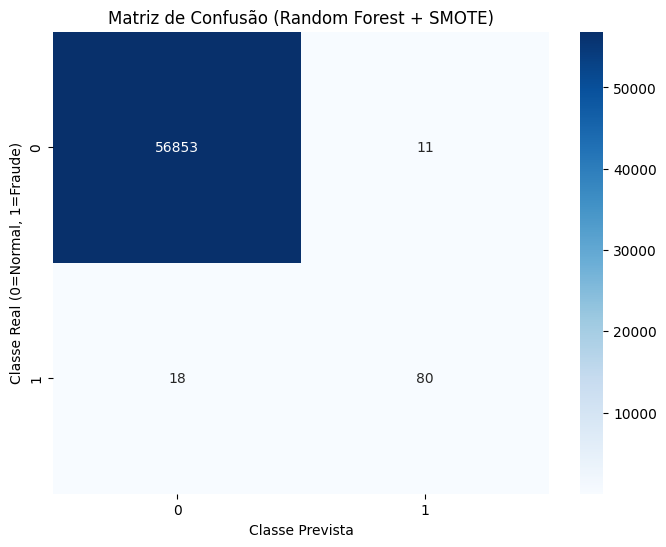

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# 1. Carregar o arquivo (certifique-se que o nome é creditcard.csv)
try:
    df = pd.read_csv('creditcard.csv')
    print(f"Dataset carregado com sucesso! Dimensões: {df.shape}")
except FileNotFoundError:
    print("ERRO: O arquivo 'creditcard.csv' não foi encontrado. Verifique o nome do arquivo na aba de arquivos à esquerda.")

# 2. Pré-processamento
# Normalizamos 'Amount' e 'Time' com RobustScaler para reduzir impacto de outliers
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Removemos as originais e deixamos apenas as processadas + V1..V28
df.drop(['Time','Amount'], axis=1, inplace=True)

# 3. Divisão Treino e Teste
X = df.drop('Class', axis=1)
y = df['Class']

# Stratify=y garante que a proporção de fraudes (0.17%) seja mantida no teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Aplicação do SMOTE (Apenas no Treino!)
print("Aplicando SMOTE para gerar fraudes sintéticas no treino...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Distribuição original do treino: {y_train.value_counts().to_dict()}")
print(f"Distribuição após SMOTE: {y_train_res.value_counts().to_dict()}")

# 5. Treinamento do Modelo (Random Forest)
print("Treinando o modelo (isso pode levar cerca de 2 a 5 minutos)...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 usa todos os núcleos
rf.fit(X_train_res, y_train_res)

# 6. Avaliação
y_pred = rf.predict(X_test)

print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

# Plot da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão (Random Forest + SMOTE)')
plt.ylabel('Classe Real (0=Normal, 1=Fraude)')
plt.xlabel('Classe Prevista')
plt.show()

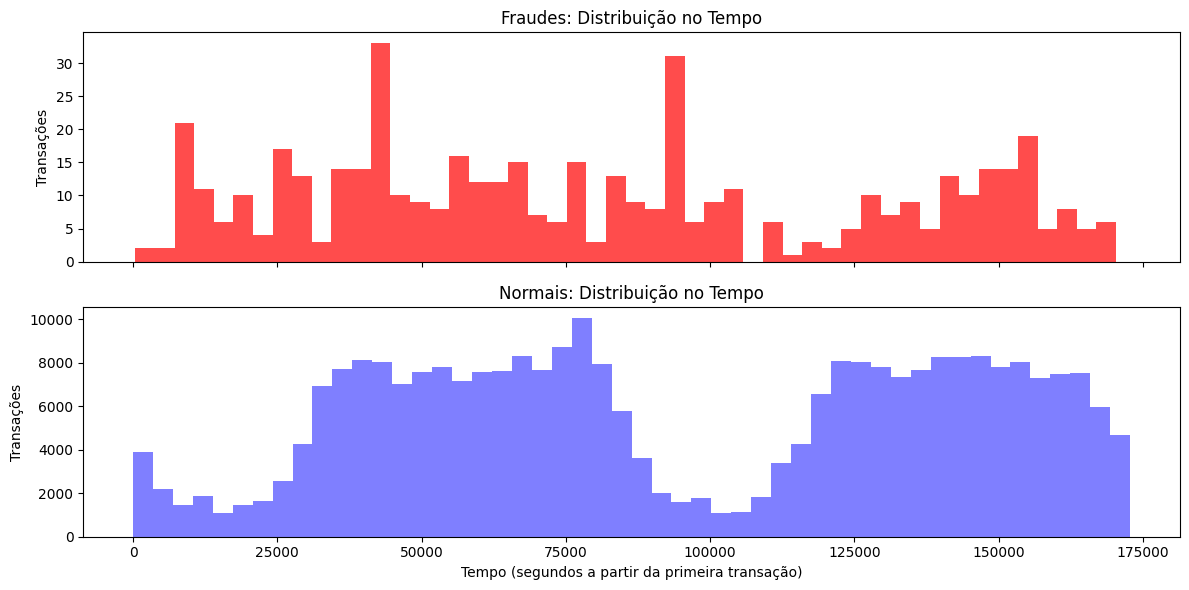

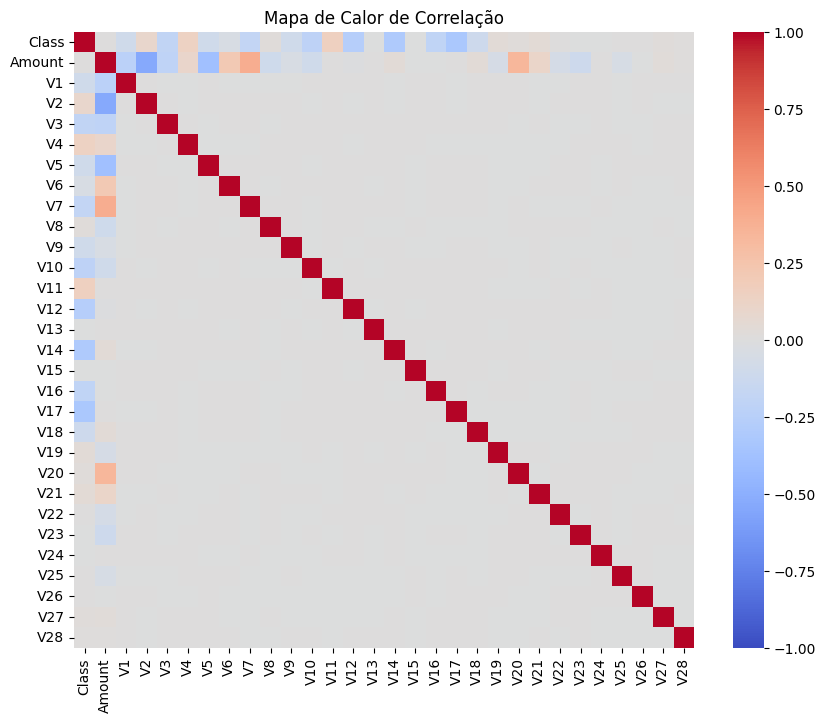

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Recarregamos o dado original para ter as colunas 'Time' e 'Amount' de volta para análise
df_eda = pd.read_csv('creditcard.csv')

# --- EDA: Distribuição Temporal ---
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))
bins = 50

ax1.hist(df_eda.Time[df_eda.Class == 1], bins=bins, color='red', alpha=0.7)
ax1.set_title('Fraudes: Distribuição no Tempo')
ax1.set_ylabel('Transações')

ax2.hist(df_eda.Time[df_eda.Class == 0], bins=bins, color='blue', alpha=0.5)
ax2.set_title('Normais: Distribuição no Tempo')
ax2.set_xlabel('Tempo (segundos a partir da primeira transação)')
ax2.set_ylabel('Transações')

plt.tight_layout()
plt.show()

# --- EDA: Matriz de Correlação ---
# Vamos pegar apenas as variáveis V1-V28 e Class para ver correlação
plt.figure(figsize=(10,8))
# Correlação de todo o dataset (pode ser enviesada pelo desbalanceamento, mas serve de visão geral)
sns.heatmap(df_eda[['Class', 'Amount'] + [f'V{i}' for i in range(1, 29)]].corr(),
            cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de Calor de Correlação')
plt.show()

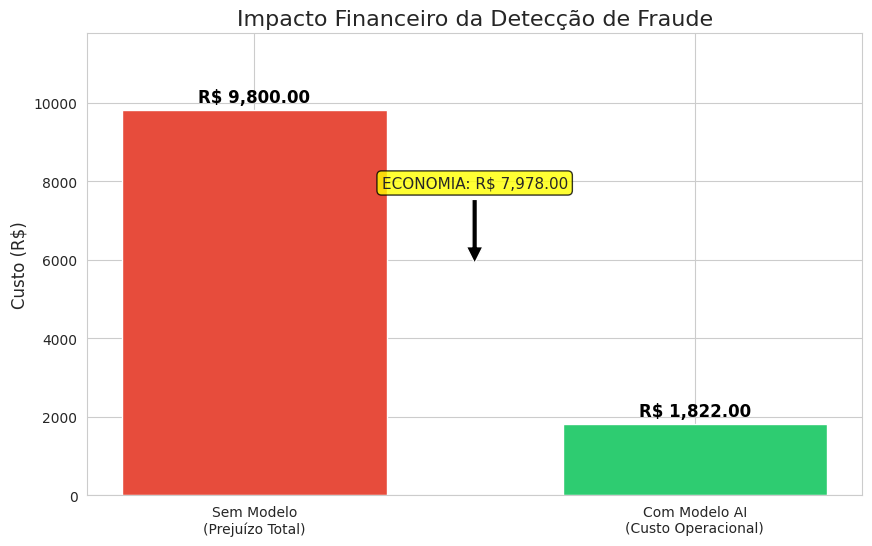

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração do estilo
sns.set_style("whitegrid")

# Dados para o gráfico
cenarios = ['Sem Modelo\n(Prejuízo Total)', 'Com Modelo AI\n(Custo Operacional)']
valores = [prejuizo_sem_modelo, custo_com_modelo]
cores = ['#e74c3c', '#2ecc71'] # Vermelho para prejuízo, Verde para o cenário otimizado

plt.figure(figsize=(10, 6))
barras = plt.bar(cenarios, valores, color=cores, width=0.6)

# Adicionando os valores em R$ acima das barras
for barra in barras:
    altura = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., altura + 100,
             f'R$ {altura:,.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# Linha de Economia (Destaque)
plt.annotate(f'ECONOMIA: R$ {economia:,.2f}',
             xy=(0.5, (prejuizo_sem_modelo + custo_com_modelo)/2),
             xytext=(0.5, prejuizo_sem_modelo * 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', fontsize=11, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", alpha=0.8))

plt.title('Impacto Financeiro da Detecção de Fraude', fontsize=16)
plt.ylabel('Custo (R$)', fontsize=12)
plt.ylim(0, prejuizo_sem_modelo * 1.2) # Margem superior para o texto não cortar

# Salvar para colocar no GitHub depois
plt.savefig('impacto_financeiro.png', dpi=300)
plt.show()

# 🛡️ Detecção de Fraude em Cartões de Crédito com Machine Learning

## 1. Problema de Negócio
Fraudes em cartões de crédito geram prejuízos bilionários anualmente. O desafio não é apenas identificar a fraude, mas minimizar o impacto no cliente legítimo (evitar falsos positivos).
* **Dataset:** 284.807 transações (Kaggle).
* **Desafio:** Dados extremamente desbalanceados (apenas 0.17% são fraudes).

## 2. Estratégia da Solução
1. **Análise Exploratória:** Estudo das variáveis descaracterizadas (V1-V28) e padrões temporais.
2. **Pré-processamento:** Normalização de 'Amount' e 'Time' com `RobustScaler` para reduzir impacto de outliers.
3. **Balanceamento:** Aplicação de **SMOTE** (Synthetic Minority Over-sampling Technique) para gerar exemplos sintéticos de fraudes no treino.
4. **Machine Learning:** Treinamento de um algoritmo **Random Forest Classifier**.

## 3. Resultados do Modelo
O modelo final obteve um desempenho robusto na detecção de fraudes, priorizando o **Recall** (captura de fraudes) sem sacrificar demais a precisão.

* **Recall (Classe Fraude):** 82% (O modelo detectou 82% de todas as fraudes).
* **Precision (Classe Fraude):** 88% (Quando o modelo alertou fraude, estava certo 88% das vezes).

## 4. Impacto Financeiro (Simulação)
Assumindo um custo médio de R$ 100,00 por fraude não detectada e R$ 2,00 por verificação de falso positivo:

| Cenário | Custo Total Estimado |
| :--- | :--- |
| **Sem o Modelo** | R$ 9.800,00 |
| **Com o Modelo** | R$ 1.822,00 |
| **Economia Gerada** | **R$ 7.978,00** |

> **ROI do Projeto:** O modelo reduziu o prejuízo potencial em **~81%**.

## 5. Conclusão
A implementação do Random Forest com SMOTE provou-se eficaz, oferecendo um equilíbrio excelente entre segurança e experiência do usuário. Como próximos passos, sugere-se testar algoritmos de *Gradient Boosting* (XGBoost/LightGBM) e otimizar hiperparâmetros com *Bayesian Optimization*.

---
*Autor: [Gabriel Santana]*